<a href="https://colab.research.google.com/github/Sofigam00s/Aprendizaje-Automatico-2-IA/blob/main/AA2_TP2_MLP_KAN_GAMALLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**Sofia Antonia Gamallo**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

In [398]:
# Librerías
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
warnings.filterwarnings("ignore")

In [399]:
!pip install pykan

In [400]:
from kan import *

In [401]:
def fijar_semillas(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para múltiples GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

fijar_semillas(42)

In [402]:
# prompt de Copilot: generar el dataset sintético con distribuciones variadas:

def generar_dataset_sintetico(n=1000, seed=7):
    np.random.seed(seed)

    # Features
    x1 = np.random.normal(loc=2, scale=0.8, size=n)           # Normal centrada en 2
    x2 = np.random.uniform(low=0, high=10, size=n)            # Uniforme amplia
    x3 = np.random.gamma(shape=2, scale=1.5, size=n)          # Distribución gamma (asimétrica)
    x4 = np.random.triangular(left=1, mode=3, right=5, size=n) # Triangular (preferencia por valores medios)

    # Target
    ruido = np.random.normal(loc=0, scale=0.6, size=n)
    y = (
        0.8 * x1 +                         # lineal
        np.sin(x2 / 2) +                   # trigonométrica suavizada
        np.log1p(x3) +                     # logarítmica
        np.gradient(x4) +                  # derivada numérica aproximada
        ruido
    )

    df = pd.DataFrame({
        'x1_normal': x1,
        'x2_uniform': x2,
        'x3_gamma': x3,
        'x4_triangular': x4,
        'target': y
    })

    return df


In [403]:
# Mostrar el dataset
df = generar_dataset_sintetico()
df.head()

,x1_normal,x2_uniform,x3_gamma,x4_triangular,target
0,3.352421,2.603982,0.329456,1.983679,4.641837
1,1.627250,7.332158,4.976170,2.602160,2.907314
2,2.026256,5.275802,1.296310,2.970274,3.593022
3,2.326013,8.605275,4.313463,3.469187,3.436248
4,1.368862,0.760418,3.225849,3.459179,3.333822


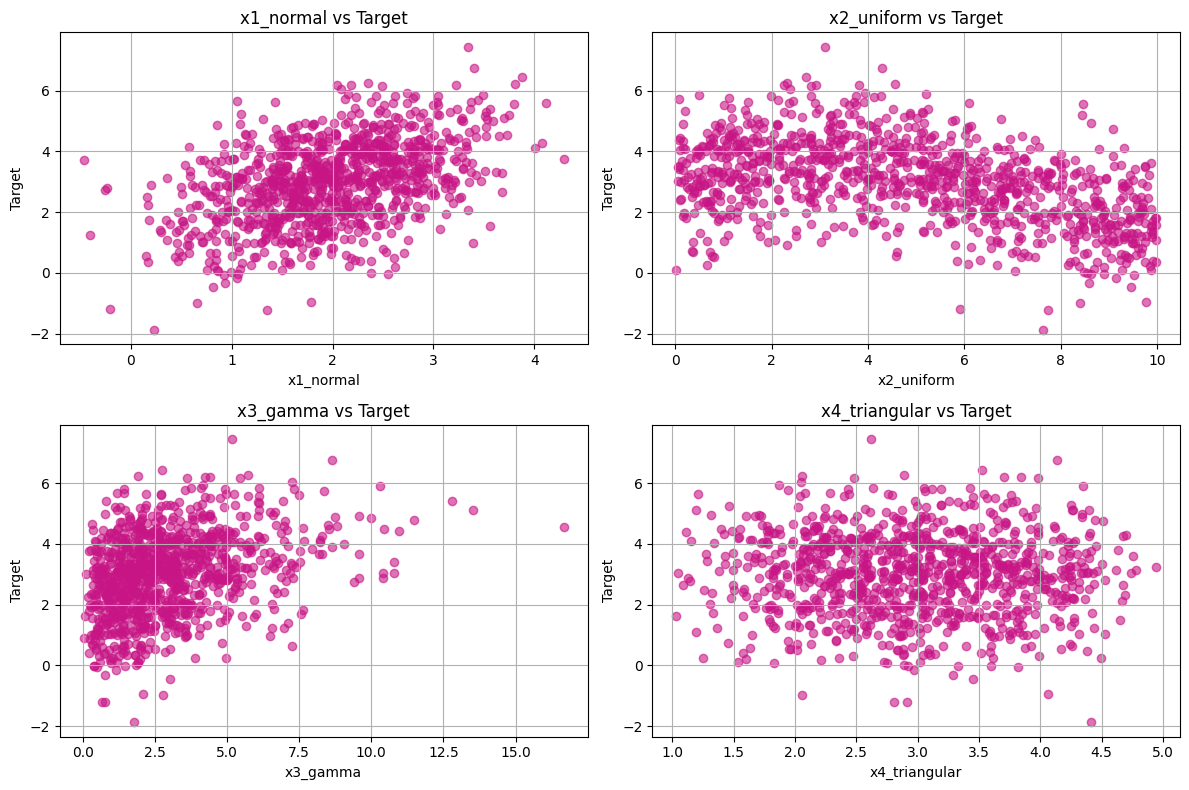

In [404]:
# Lista de nombres de las features
features = df.drop(columns='target').columns

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # ajustá según cantidad de features
axs = axs.ravel()

for i, feature in enumerate(features):
    axs[i].scatter(df[feature], df['target'], alpha=0.6, c='mediumvioletred')
    axs[i].set_title(f'{feature} vs Target')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Target')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


### Preparación de datos

Paso a dividir el conjunto de datos en entrenamiento, validación y testeo.
Estandarizo con StandarScaler y por último convierto los datos a tensores de Pytorch

In [405]:
# Dividir las features y el target
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividir en entrenamiento + testeo (70/30)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Dividir X_temp en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# Estandarizar los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)


### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


#### Armar la arquitectura de la red MLP

 Voy a crear una clase para la arquitectura de red MLP con las 4 variables creadas anteriormente (que serían las entradas de la red), la cantidad de capas ocultas que después se pueden modificar, la capa de salida y la función de activación ReLU.

In [406]:
class MLP(nn.Module):

    def __init__(self, input_size=4, hidden_size=20, output_size=1):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

Ahora voy a crear una función por defecto para entrenar la red MLP.

Ésta función lo que va a hacer es recibir el modelo, los datos train/test/val y algunos parámetros como la cantidad de épocas, el tamaño del batch, la tasa de aprendizaje y si quiero usar regularización L2.

Agrego el criterio de pérdida (MSE), el optimizador Adam y armo el Dataloader para entrenar por batches.

En las épocas se entrena el modelo con los datos de train y depues se evaluan con los datos de validacion y testeo.

In [407]:
def entrenar_mlp(model, X_train, y_train, X_val, y_val, X_test, y_test,
                 epochs=100, lr=0.01, weight_decay=0.0, batch_size=32):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Crear DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluación en validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val).squeeze()
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"  Época {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Evaluación final en test
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test).squeeze()
        test_loss_final = criterion(test_pred, y_test).item()

    return train_losses, val_losses, test_loss_final

#### Red que **subajusta**

  Época 1/10 - Train Loss: 1.5700, Val Loss: 1.3823
  - Train Loss: 0.6363
  - Validation Loss: 0.7728
  - Test Loss: 0.6309


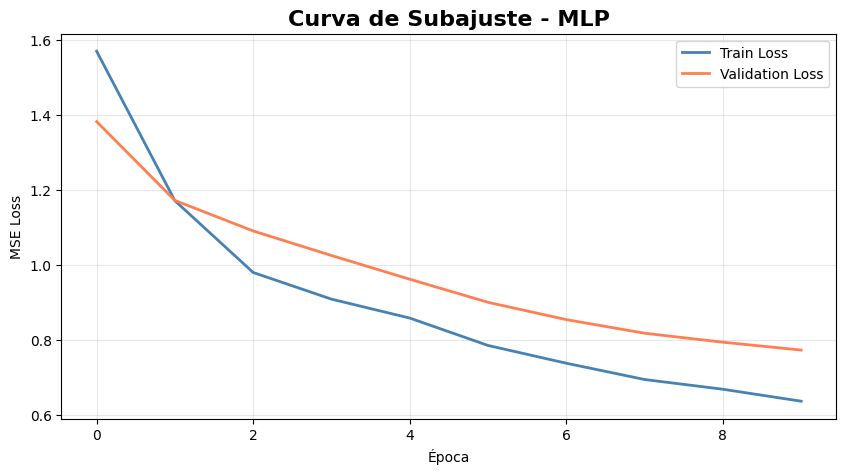

In [408]:
fijar_semillas(42)
mlp_sub = MLP(input_size=4, hidden_size=2, output_size=1)
train_losses_mlp_sub, val_losses_mlp_sub, test_loss_mlp_sub = entrenar_mlp(
    mlp_sub, X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor, y_test_tensor,
    epochs=10, lr=0.01, weight_decay=0.0
)

print(f"  - Train Loss: {train_losses_mlp_sub[-1]:.4f}")
print(f"  - Validation Loss: {val_losses_mlp_sub[-1]:.4f}")
print(f"  - Test Loss: {test_loss_mlp_sub:.4f}")

# Visuaizar curva de subajuste
plt.figure(figsize=(10, 5))
plt.plot(train_losses_mlp_sub ,
         label='Train Loss',
         linewidth=2, color='steelblue')
plt.plot(val_losses_mlp_sub, label='Validation Loss',
         linewidth=2, color='coral')
plt.title('Curva de Subajuste - MLP', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Red **aceptable**

  Época 1/100 - Train Loss: 0.8219, Val Loss: 0.9467
  Época 20/100 - Train Loss: 0.4757, Val Loss: 0.5400
  Época 40/100 - Train Loss: 0.4381, Val Loss: 0.5032
  Época 60/100 - Train Loss: 0.4168, Val Loss: 0.4904
  Época 80/100 - Train Loss: 0.4046, Val Loss: 0.4823
  Época 100/100 - Train Loss: 0.3885, Val Loss: 0.4793
  - Train Loss: 0.3885
  - Validation Loss: 0.4793
  - Test: 0.4287


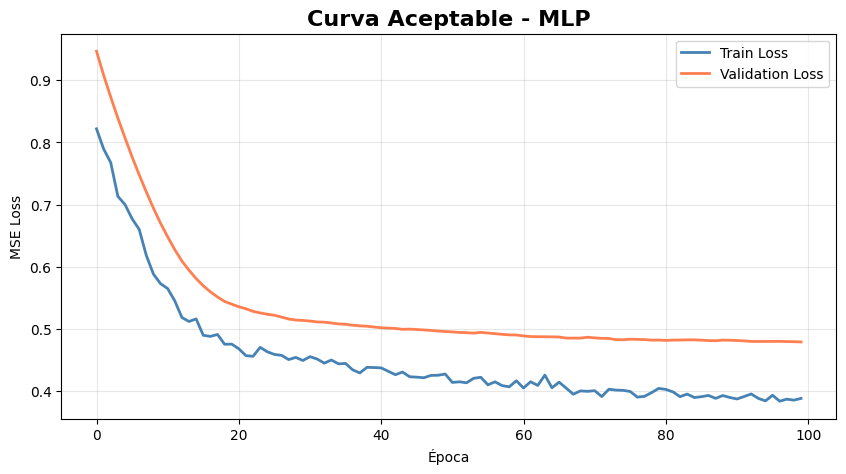

In [409]:
fijar_semillas(42)
mlp_ok = MLP(input_size=4, hidden_size=28, output_size=1)
train_losses_mlp_ok, val_losses_mlp_ok, test_loss_mlp_ok = entrenar_mlp(
    mlp_ok, X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor, y_test_tensor,
    epochs=100, lr=0.001, weight_decay=0.001, batch_size=75
)

print(f"  - Train Loss: {train_losses_mlp_ok[-1]:.4f}")
print(f"  - Validation Loss: {val_losses_mlp_ok[-1]:.4f}")
print(f"  - Test: {test_loss_mlp_ok:.4f}")

# Visualizar curva aceptable
plt.figure(figsize=(10, 5))
plt.plot(train_losses_mlp_ok, label='Train Loss', linewidth=2, color='steelblue')
plt.plot(val_losses_mlp_ok, label='Validation Loss', linewidth=2, color='coral')
plt.title('Curva Aceptable - MLP', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Red que **sobreajusta**

  Época 1/300 - Train Loss: 0.6438, Val Loss: 0.5732
  Época 20/300 - Train Loss: 0.3699, Val Loss: 0.5488
  Época 40/300 - Train Loss: 0.3396, Val Loss: 0.5616
  Época 60/300 - Train Loss: 0.3276, Val Loss: 0.5745
  Época 80/300 - Train Loss: 0.3335, Val Loss: 0.6093
  Época 100/300 - Train Loss: 0.3269, Val Loss: 0.6371
  Época 120/300 - Train Loss: 0.2949, Val Loss: 0.6332
  Época 140/300 - Train Loss: 0.2821, Val Loss: 0.6659
  Época 160/300 - Train Loss: 0.2760, Val Loss: 0.7184
  Época 180/300 - Train Loss: 0.2608, Val Loss: 0.7177
  Época 200/300 - Train Loss: 0.3069, Val Loss: 0.9050
  Época 220/300 - Train Loss: 0.2646, Val Loss: 0.7670
  Época 240/300 - Train Loss: 0.2799, Val Loss: 0.7706
  Época 260/300 - Train Loss: 0.2325, Val Loss: 0.7702
  Época 280/300 - Train Loss: 0.2611, Val Loss: 0.7585
  Época 300/300 - Train Loss: 0.2372, Val Loss: 0.7108
  - Train Loss: 0.2372
  - Validation Loss: 0.7108
  - Test Loss: 0.6334


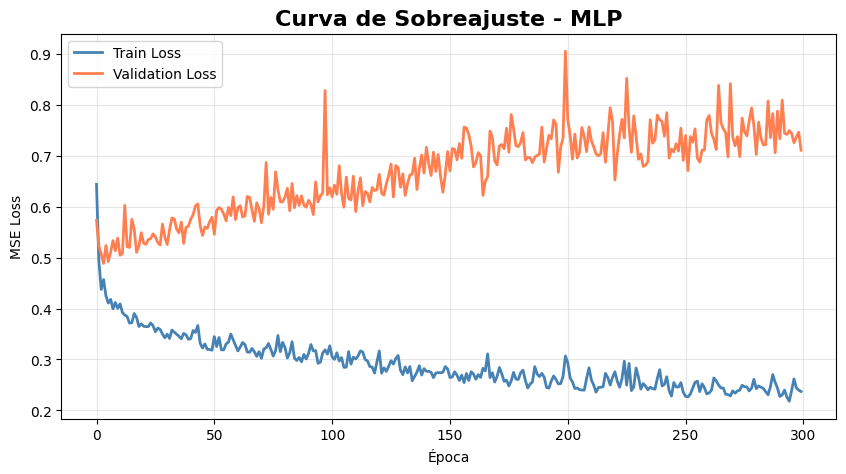

In [410]:
fijar_semillas(42)
mlp_sob = MLP(input_size=4, hidden_size=100, output_size=1)
train_losses_mlp_sob, val_losses_mlp_sob, test_loss_mlp_sob = entrenar_mlp(
    mlp_sob, X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor, y_test_tensor,
    epochs=300, lr=0.01, weight_decay=0.0
)

print(f"  - Train Loss: {train_losses_mlp_sob[-1]:.4f}")
print(f"  - Validation Loss: {val_losses_mlp_sob[-1]:.4f}")
print(f"  - Test Loss: {test_loss_mlp_sob:.4f}")

#Visualizar curva de sobreajuste
plt.figure(figsize=(10, 5))
plt.plot(train_losses_mlp_sob, label='Train Loss', linewidth=2, color='steelblue')
plt.plot(val_losses_mlp_sob, label='Validation Loss', linewidth=2, color='coral')
plt.title('Curva de Sobreajuste - MLP', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

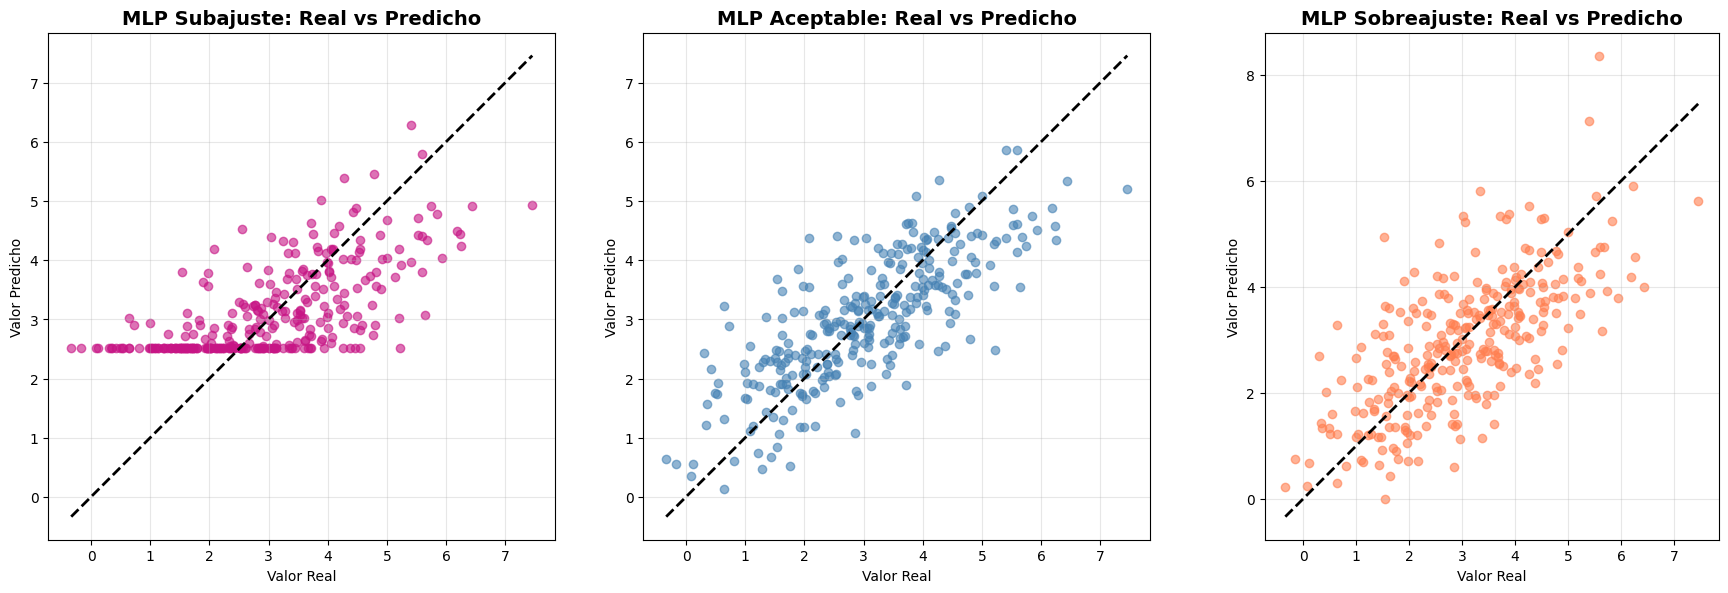

In [411]:
# Comparación de resultados MLP:

# Desescalar las predicciones y valores reales para visualización
y_test_real = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()

# MLP Underfitting
mlp_sub.eval()
with torch.no_grad():
    y_pred_mlp_sub_scaled = mlp_sub(X_test_tensor).squeeze().numpy()
y_pred_mlp_sub = scaler_y.inverse_transform(y_pred_mlp_sub_scaled.reshape(-1, 1)).flatten()

# MLP Aceptable
mlp_ok.eval()
with torch.no_grad():
    y_pred_mlp_ok_scaled = mlp_ok(X_test_tensor).squeeze().numpy()
y_pred_mlp_ok = scaler_y.inverse_transform(y_pred_mlp_ok_scaled.reshape(-1, 1)).flatten()

# MLP Overfitting
mlp_sob.eval()
with torch.no_grad():
    y_pred_mlp_sob_scaled = mlp_sob(X_test_tensor).squeeze().numpy()
y_pred_mlp_sob = scaler_y.inverse_transform(y_pred_mlp_sob_scaled.reshape(-1, 1)).flatten()


# Crear subplots para comparar
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Underfitting
axs[0].scatter(y_test_real, y_pred_mlp_sub, alpha=0.6, color='mediumvioletred')
axs[0].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'k--', lw=2) # Línea ideal
axs[0].set_title('MLP Subajuste: Real vs Predicho', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Valor Real')
axs[0].set_ylabel('Valor Predicho')
axs[0].grid(True, alpha=0.3)
axs[0].set_aspect('equal', adjustable='box')


# Plot Aceptable
axs[1].scatter(y_test_real, y_pred_mlp_ok, alpha=0.6, color='steelblue')
axs[1].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'k--', lw=2) # Línea ideal
axs[1].set_title('MLP Aceptable: Real vs Predicho', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Valor Real')
axs[1].set_ylabel('Valor Predicho')
axs[1].grid(True, alpha=0.3)
axs[1].set_aspect('equal', adjustable='box')


# Plot Overfitting
axs[2].scatter(y_test_real, y_pred_mlp_sob, alpha=0.6, color='coral')
axs[2].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'k--', lw=2) # Línea ideal
axs[2].set_title('MLP Sobreajuste: Real vs Predicho', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Valor Real')
axs[2].set_ylabel('Valor Predicho')
axs[2].grid(True, alpha=0.3)
axs[2].set_aspect('equal', adjustable='box')


plt.tight_layout()
plt.show()

En esta comparación se puede notar a simple vista el subajuste en relación a los valores reales con que se predijeron, no hay una correcta relación entre ellos.

Por otro lado, el modelo aceptable y el de sobreajuste comparten una gran similitud, la diferencia esta en los valores que se dieron en el entrenemiento, donde el modelo de sobreajuste mostró una mejoría en el resultado de MSE, pero cuando se probó en el testeo, el rendimiento bajó muchisimo. Por lo tanto en este caso se puede mostrar con seguridad que el mejor modelos es realmente el aceptable.




### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



#### Armar la arquitectura para la red KAN y estructurar los datos correctamente

Para armar la red se utilizan los mismos parámetros que en MLP. En este punto me ayudé con la IA Claude, porque me resultó un poco difícil encontrar la documentación más correcta para esta consigna.

In [412]:
def entrenar_kan(model, data, steps=100, lr=0.01, lamb=0.0):
    train_losses = []
    test_losses = []

    # Entrenar el modelo
    results = model.fit(data, opt="Adam", steps=steps, lr=lr, lamb=lamb)

    # Extraer las pérdidas de los resultados
    train_losses = results['train_loss']
    test_losses = results['test_loss']

    return train_losses, test_losses, results

In [413]:
data_kan = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor.unsqueeze(1),
    'test_input': X_test_tensor,
    'test_label': y_test_tensor.unsqueeze(1)
}

print(f"  - Train input shape: {data_kan['train_input'].shape}")
print(f"  - Train label shape: {data_kan['train_label'].shape}")
print(f"  - Test input shape: {data_kan['test_input'].shape}")
print(f"  - Test label shape: {data_kan['test_label'].shape}")

  - Train input shape: torch.Size([560, 4])
  - Train label shape: torch.Size([560, 1])
  - Test input shape: torch.Size([300, 4])
  - Test label shape: torch.Size([300, 1])


#### Red que **subajusta**

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.89e-01 | test_loss: 8.95e-01 | reg: 7.61e+00 | : 100%|█| 10/10 [00:00<00:00, 47.57it


saving model version 0.1
  - Train Loss: 0.8887
  - Test Loss: 0.8952


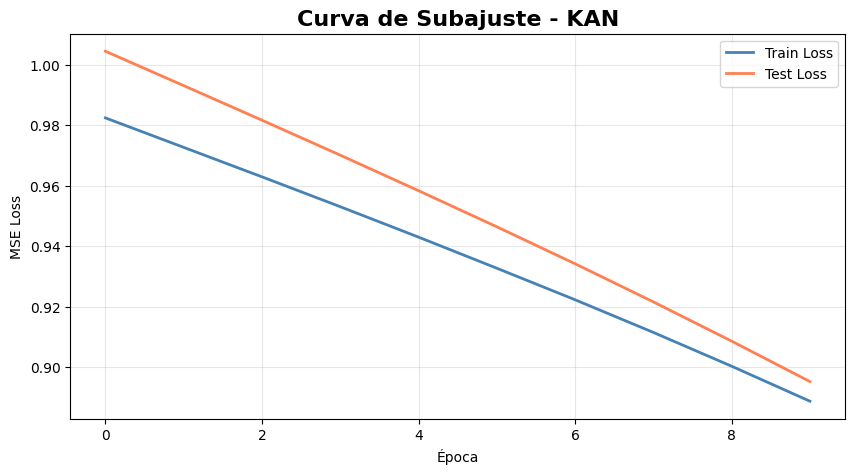


Visualización de la red KAN (subajuste):


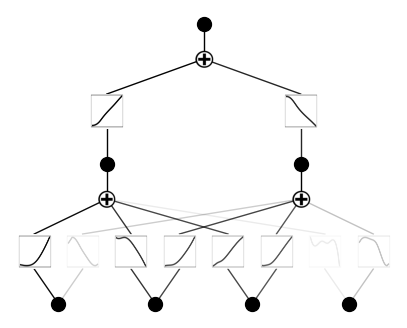

In [414]:
fijar_semillas(42)
kan_sub = KAN(width=[4, 2, 1], grid=3, k=3, seed=42)

train_losses_kan_sub, test_losses_kan_sub, results_sub = entrenar_kan(
    kan_sub,
    data_kan,
    steps=10,
    lr=0.01,
    lamb=0.0
)

print(f"  - Train Loss: {train_losses_kan_sub[-1]:.4f}")
print(f"  - Test Loss: {test_losses_kan_sub[-1]:.4f}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_losses_kan_sub, label='Train Loss', linewidth=2, color='steelblue')
plt.plot(test_losses_kan_sub, label='Test Loss', linewidth=2, color='coral')
plt.title('Curva de Subajuste - KAN', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualizar la arquitectura aprendida
print("\nVisualización de la red KAN (subajuste):")
kan_sub.plot()

#### Red **aceptable**

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.89e-01 | test_loss: 6.68e-01 | reg: 2.14e+01 | : 100%|█| 70/70 [00:02<00:00, 23.75it


saving model version 0.1
  - Train Loss: 0.5886
  - Test Loss: 0.6682


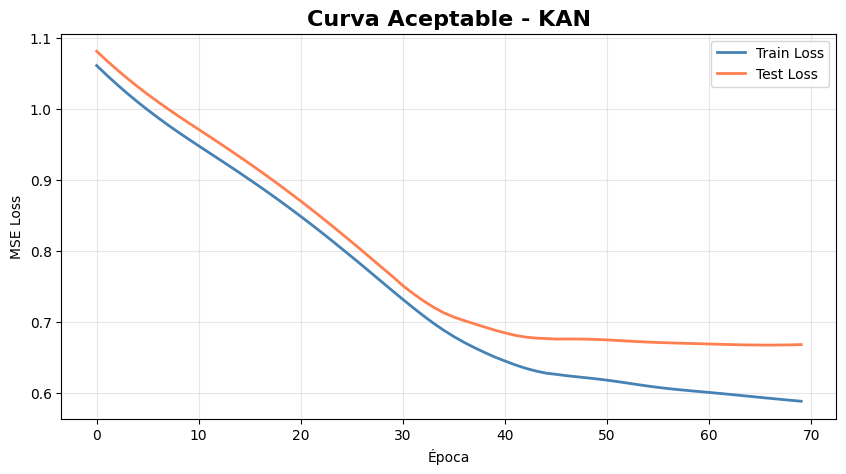


Visualización de la red KAN (aceptable):


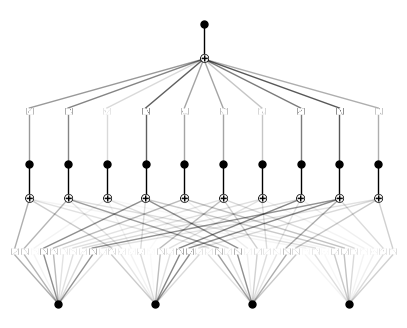

In [415]:
fijar_semillas(42)

kan_ok = KAN(width=[4, 10, 1], grid=5, k=3, seed=42)

train_losses_kan_ok, test_losses_kan_ok, results_ok = entrenar_kan(
    kan_ok,
    data_kan,
    steps=70,
    lr=0.005,
    lamb=0.001
)

print(f"  - Train Loss: {train_losses_kan_ok[-1]:.4f}")
print(f"  - Test Loss: {test_losses_kan_ok[-1]:.4f}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_losses_kan_ok, label='Train Loss', linewidth=2, color='steelblue')
plt.plot(test_losses_kan_ok, label='Test Loss', linewidth=2, color='coral')
plt.title('Curva Aceptable - KAN', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualizar la arquitectura aprendida
print("\nVisualización de la red KAN (aceptable):")
kan_ok.plot()

#### Red que **sobreajusta**

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.34e-02 | test_loss: 1.12e+00 | reg: 3.02e+01 | : 100%|█| 300/300 [00:08<00:00, 34.43


saving model version 0.1
  - Train Loss: 0.0634
  - Test Loss: 1.1235


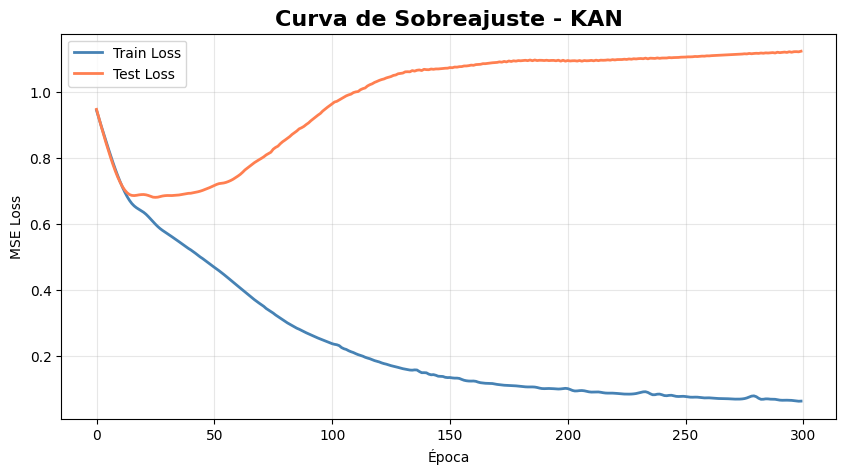


Visualización de la red KAN (sobreajuste):


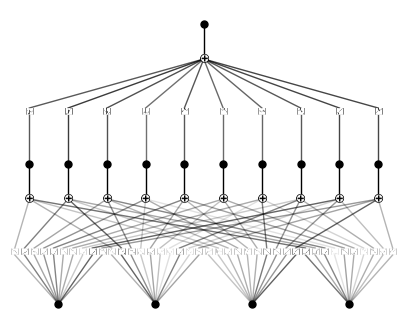

In [416]:
fijar_semillas(42)

kan_sob = KAN(width=[4, 10, 1], grid=10, k=3, seed=42)

train_losses_kan_sob, test_losses_kan_sob, results_sob = entrenar_kan(
    kan_sob,
    data_kan,
    steps=300,
    lr=0.01,
    lamb=0.0
)

print(f"  - Train Loss: {train_losses_kan_sob[-1]:.4f}")
print(f"  - Test Loss: {test_losses_kan_sob[-1]:.4f}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_losses_kan_sob, label='Train Loss', linewidth=2, color='steelblue')
plt.plot(test_losses_kan_sob, label='Test Loss', linewidth=2, color='coral')
plt.title('Curva de Sobreajuste - KAN', fontsize=16, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualizar la arquitectura aprendida
print("\nVisualización de la red KAN (sobreajuste):")
kan_sob.plot()

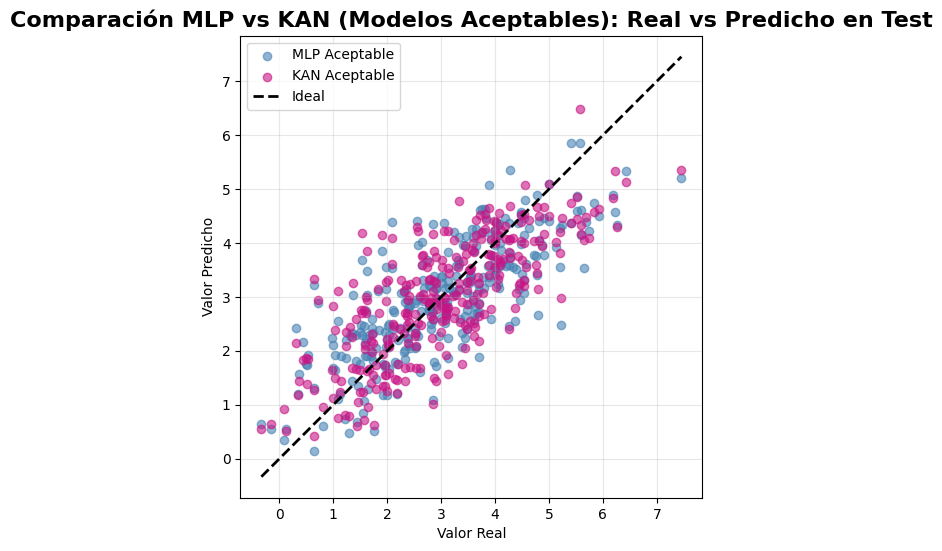

In [417]:
# Comparación de modelos aceptables (MLP vs KAN)

# KAN Aceptable - obtener predicciones y desescalar
kan_ok.eval()
with torch.no_grad():
    y_pred_kan_ok_scaled = kan_ok(X_test_tensor).squeeze().numpy()
y_pred_kan_ok = scaler_y.inverse_transform(y_pred_kan_ok_scaled.reshape(-1, 1)).flatten()


plt.figure(figsize=(10, 6))

# Plot MLP Aceptable
plt.scatter(y_test_real, y_pred_mlp_ok, alpha=0.6, color='steelblue', label='MLP Aceptable')

# Plot KAN Aceptable
plt.scatter(y_test_real, y_pred_kan_ok, alpha=0.6, color='mediumvioletred', label='KAN Aceptable')


plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'k--', lw=2, label='Ideal') # Línea ideal

plt.title('Comparación MLP vs KAN (Modelos Aceptables): Real vs Predicho en Test', fontsize=16, fontweight='bold')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [419]:
resultados = [
    ("MLP", "Subajuste", train_losses_mlp_sub[-1], val_losses_mlp_sub[-1], test_loss_mlp_sub),
    ("MLP", "Solución Aceptable", train_losses_mlp_ok[-1], val_losses_mlp_ok[-1], test_loss_mlp_ok),
    ("MLP", "Sobreajuste", train_losses_mlp_sob[-1], val_losses_mlp_sob[-1], test_loss_mlp_sob),
    ("KAN", "Subajuste", train_losses_kan_sub[-1], test_losses_kan_sub[-1], test_losses_kan_sub[-1]),
    ("KAN", "Solución Aceptable", train_losses_kan_ok[-1], test_losses_kan_ok[-1], test_losses_kan_ok[-1]),
    ("KAN", "Sobreajuste", train_losses_kan_sob[-1], test_losses_kan_sob[-1], test_losses_kan_sob[-1]),
]

print(f"{'Modelo':<15} {'Configuración':<20} {'Train Loss':<12} {'Test Loss':<12} {'Test Loss Final':<15} {'Train/Test':<15}")
print("-" * 90)

for modelo, config, train_loss, test_loss, test_loss_final in resultados:
    gap = abs(train_loss - test_loss)
    print(f"{modelo:<15} {config:<20} {train_loss:<12.4f} {test_loss:<12.4f} {test_loss_final:<15.4f} {gap:<15.4f}")

Modelo          Configuración        Train Loss   Test Loss    Test Loss Final Train/Test     
------------------------------------------------------------------------------------------
MLP             Subajuste            0.6363       0.7728       0.6309          0.1365         
MLP             Solución Aceptable   0.3885       0.4793       0.4287          0.0908         
MLP             Sobreajuste          0.2372       0.7108       0.6334          0.4736         
KAN             Subajuste            0.8887       0.8952       0.8952          0.0065         
KAN             Solución Aceptable   0.5886       0.6682       0.6682          0.0797         
KAN             Sobreajuste          0.0634       1.1235       1.1235          1.0601         


### **4. Conclusiones y Análisis**  
- Comparar **MLP vs KAN** en términos de:  
  - Capacidad de aproximación.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¿Cuál modelo es más flexible?  
  - ¿En qué casos conviene usar KAN?  



* **Comparación de modelos:**

  En cuánto a la aproximación, puedo decir que la red MLP fue mejor que la KAN, ya que el resultado del MSE fue del 47% a comparación del 66% de KAN.

  En la sensibildad, KAN tiene mayor probabilidad de obtener un sub o sobreajuste, que tiene sentido porque se aplican modelos de activación a cada neurona.

  En interpretabilidad, las dos redes tienen el mismo vocabulario, salvo alguna palabra como stepts/épocas, pero lo demás es muy similar y fácil de leer y comparar.

* **Discución:**

  Considero que el modelo más flexible por el momento son las redes MLP, porque las redes KAN creo que todavía son muy nuevas y no hay tanta información y ejemplos que se puedan encontrar en internet. En cambio con las redes MLP hay mucha información sobre hipérparametros o configuraciones de su arquitectura que pueden lograr un mejor resultado. Sin embargo no niego que KAN puede lograr mucha más flexibilidad con el conocimiento adecuado.

  Los mejores casos para aplicar KAN pueden ser donde existe mucha aleatoriedad en el comportamiento de los datos. Quiero decir, cuando un dato funciona de una manera que sea dificil de predecir, incluso para las redes MLP, KAN puede adaptarse muy bien a esta situación porque las funciones de activación que se aplican son vairadas y permiten aprender y predecir la ruta que puede llegar a tener ese dato.


**Conclusiones**

En este trabajo cree un dataset sintetico de funciones variadas con el objetivo de probar el funcionamiento de redes neuronales MLP y KAN y comparan su comportamiento y eficiencia.

Las dos redes tuvieron una correcta respuesta en cuanto a obtener un resultado de subajuste, sobreajuste y tuvieron un comportamiento muy similar (no así el puntaje) del resultado aceptable. La red KAN fue más sensible a generar este sub y sobreajuste.

En mi caso personal, la mejor red neuronal que funcionó fue MLP, probé demasiadas configuraciones diferentes de hiperparámetros para KAN pero el mejor puntaje que pude obtener fue un MSE de 66%.


## **5- Referencias**

Debe citar y mencionar todas las herramientas utilizadas.

Si utiliza una IA (GPT), especifique los prompts utilizados y salidas.



* https://www.datacamp.com/es/tutorial/kolmogorov-arnold-networks
* https://github.com/yu-rp/KANbeFair

Para este trabajo me ayude mucho de Copilot, Chat-GPT y Claude para armar la arquitectura de las redes, sobre todo de la red KAN porque me costó encontrar información específica de lo que necesitaba.